In [1]:
!pip install basix -qqq

In [2]:
!pip install matplotlib -qqq

In [3]:
import os
from urllib.parse import quote_plus
from pc_zap_scrapper.v2.database import DatabaseHandler, TableRealEstateInfo

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import matplotlib.ticker as mticker

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from basix.viz import ColorMix

mkdir -p failed for path /home/jovyan/.cache/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-aqrt2yhd because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Functions

In [4]:
def view_colors(colors):
    # Criar a figura
    fig, ax = plt.subplots(figsize=(10, 2))
    
    # Adicionar retângulos coloridos
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    
    # Ajustar os limites e remover os eixos
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Mostrar a visualização
    plt.title("Visualização da paleta de cores", y=1.1)
    plt.show()


def get_color_intensity(n_bins):

    if n_bins == 1:
        return np.array([1.0])
    if n_bins == 2:
        return np.array([1.0, 1.0])
    
    bin_range = 100 / n_bins
    distribution = norm(loc=0, scale=1)
    x = np.array([i/100 for i in np.arange(0,101, bin_range)])
    quantiles = distribution.ppf(x)
    pdf_values = distribution.pdf(quantiles) / distribution.pdf(0)
    result = np.array([min(pdf_values[i], pdf_values[i+1]) for i in range(len(pdf_values)-1)])
    result = np.array([x**3 for x in result])
    result = np.array([0.05+min(a,b) for a,b in zip(result,result[::-1])])
    return result / result.max()


In [5]:
def percentile_plot(casas, ylim, title, n_bins=20, base_color = "#E9967A", target_column="price"):
    
    bin_range = 100 / n_bins
    
    average_price_by_date = casas.groupby("search_date").agg(
        **{f"p{int(round(i))}": (target_column, lambda x, q=min(i/100,1): np.quantile(x, q)) for i in np.arange(0,101, bin_range)}
    ).reset_index()
    
    
    average_price_by_date['search_date'] = pd.to_datetime(average_price_by_date['search_date'])
    
    average_price_by_date = average_price_by_date.set_index("search_date")
    
        
    if 'search_date' in average_price_by_date.columns:
        average_price_by_date['search_date'] = pd.to_datetime(average_price_by_date['search_date'])
        average_price_by_date.set_index('search_date', inplace=True)
    else:
        average_price_by_date.index = pd.to_datetime(average_price_by_date.index)
    
    average_price_by_date.sort_index(inplace=True)
    
    percentiles = [f"p{int(round(i))}" for i in np.arange(0,101, bin_range)]
    
    
    color_mixer  = ColorMix(scale=[0,1], hex_colors=["#FFFFFF", base_color])
    colors = [color_mixer.hex_color(x) for x in get_color_intensity(n_bins)]
    
    plt.figure(figsize=(15, 8))
    
    for i in range(1, n_bins):
        
        lower = average_price_by_date[percentiles[i]]
        upper = average_price_by_date[percentiles[i+1]]
        # print(f"{i+1}: lower={lower} |upper={upper}")
    
        
        plt.fill_between(
            average_price_by_date.index,
            lower,
            upper,
            facecolor=colors[i],
                edgecolor=colors[i],
            linewidth=1,
            alpha=1,
        )
    
    # for percentile in percentiles:
    for percentile in ['p50']:
        plt.plot(
            average_price_by_date.index,
            average_price_by_date[percentile],
            color='black',
            linewidth=1.5,
            alpha=0.5
        )
    
    # Configurações do eixo X (formatação das datas)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    
    plt.xlabel('Data')
    plt.ylabel('Preço')
    plt.ylim(ylim)
    plt.title(title)
    
    # **Formatação do eixo Y para unidades monetárias**
    def formato_monetario(valor, pos):
        return f'R${valor:,.0f}'.replace(',', '.')
    
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(formato_monetario))
    
    
    plt.tight_layout()
    
    plt.grid()
    plt.show()


# Data Load

In [6]:
db_params = dict(
    user=os.getenv("PSQL_USERNAME"),
    password=quote_plus(os.getenv("PSQL_PASSWORD")),
    host=os.getenv("PSQL_HOST"),
    port=os.getenv("PSQL_PORT"),
    dbname=os.getenv("PSQL_NAME"),
)

db_handler = DatabaseHandler(db_params, table=TableRealEstateInfo, echo=False)

sql_query = """
SELECT * FROM real_estate_info
"""

data = await db_handler.query(sql_query)

await db_handler.close()

In [7]:
data["search_date"] = pd.to_datetime(data["search_date"]).dt.strftime('%Y-%m-%d')
data["price_m2"] = data["price"].astype(float) / data["floor_size"]

In [61]:
# data.info()

# Preço das casas ao longo do tempo

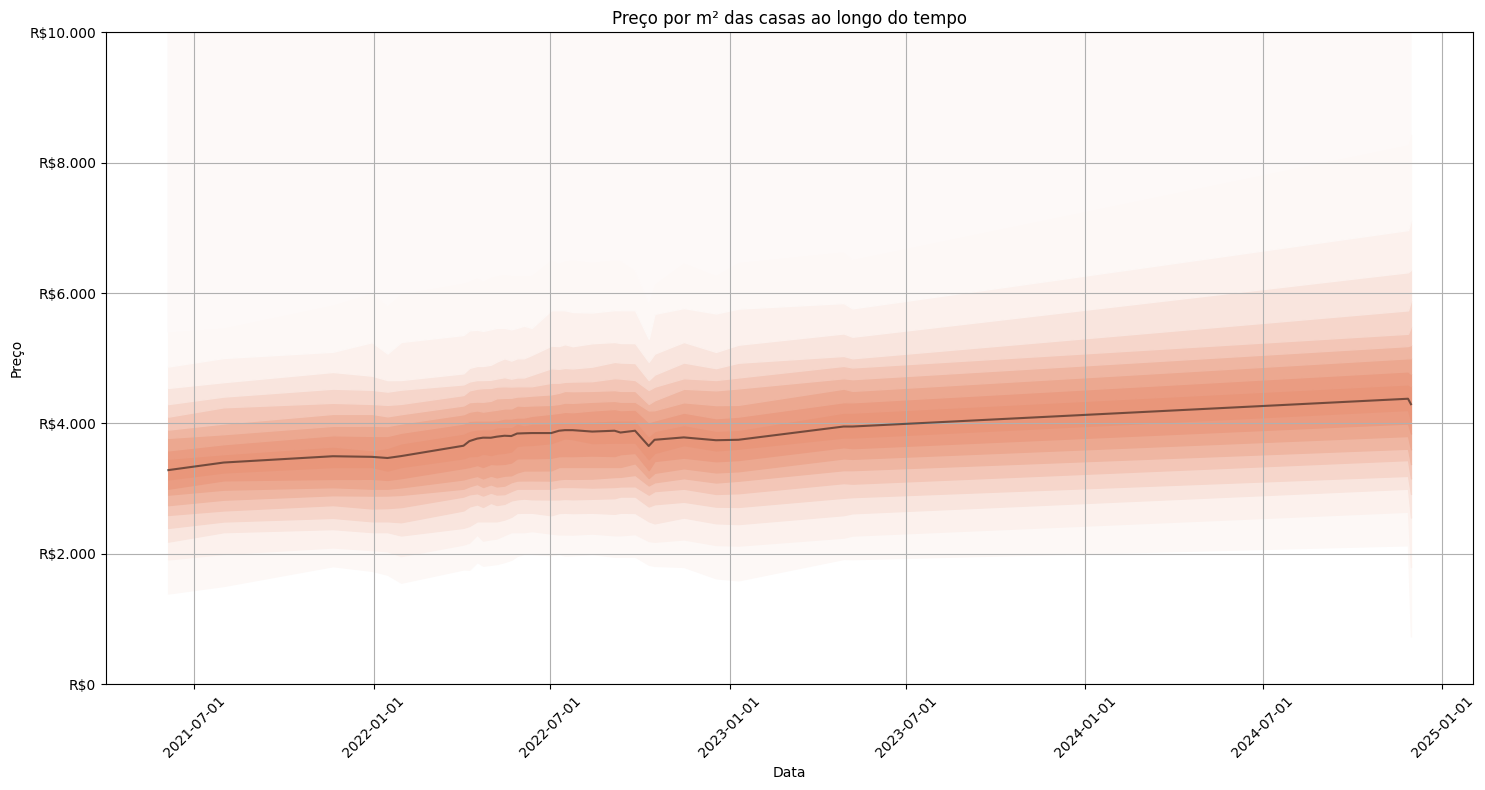

In [70]:
casas = data[data["type"] == "Casa"]
casas = casas[~casas["price_m2"].isna()]
casas = casas[casas["price_m2"] > 0]
casas["price_m2"] = casas["price_m2"].astype(float)
percentile_plot(casas, ylim=[0, 10_000], title="Preço por m² das casas ao longo do tempo", target_column="price_m2")

# Preço dos apartamentos ao longo do tempo

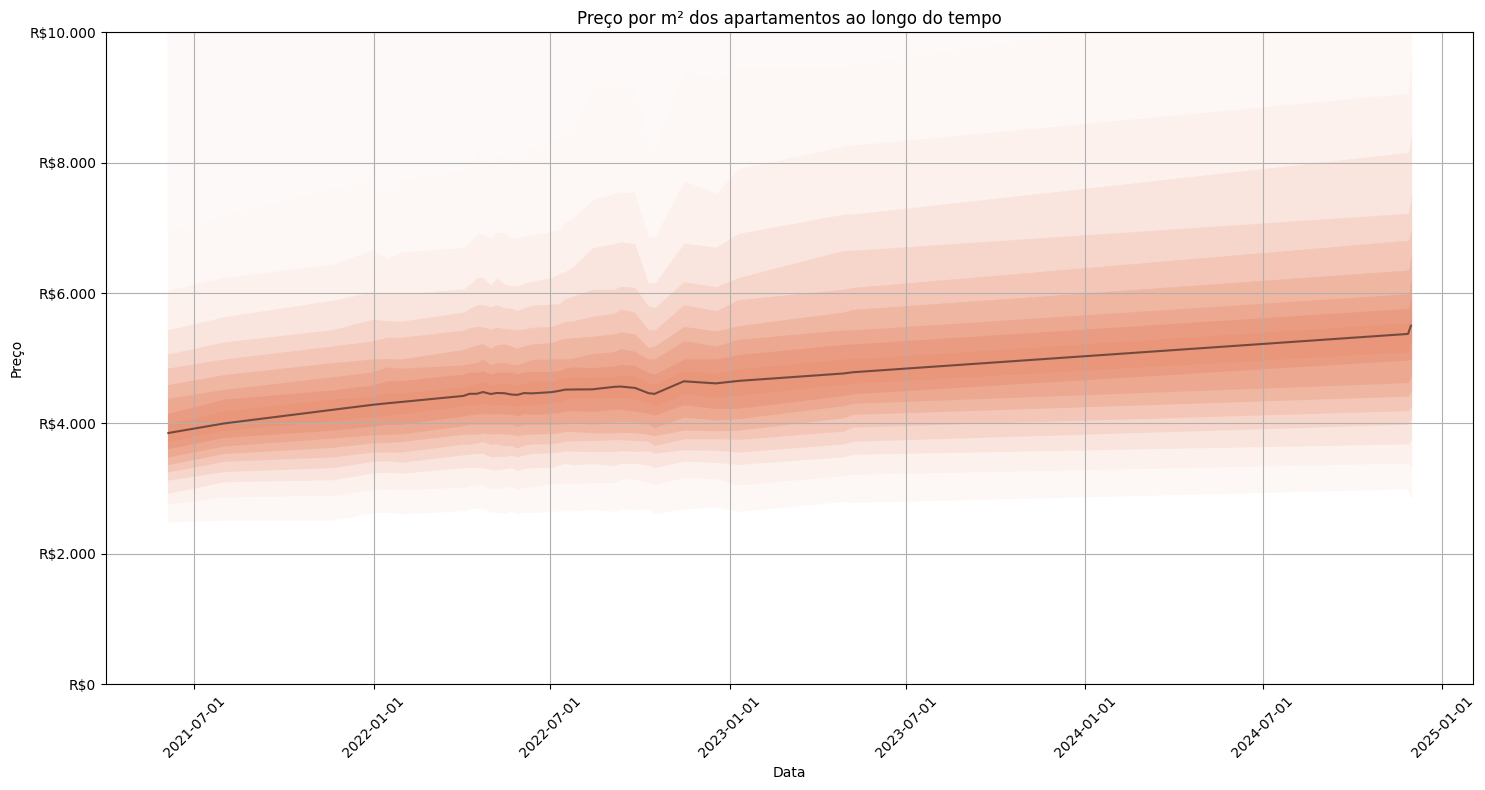

In [71]:
apartamentos = data[data["type"] == "Apartamento"]
apartamentos = apartamentos[~apartamentos["price"].isna()]
apartamentos = apartamentos[apartamentos["price"] > 0]
apartamentos["price"] = apartamentos["price"].astype(float)

percentile_plot(apartamentos, ylim=[0, 10_000], title="Preço por m² dos apartamentos ao longo do tempo", target_column="price_m2")

# Bairros

In [15]:
pd.options.display.max_columns=None

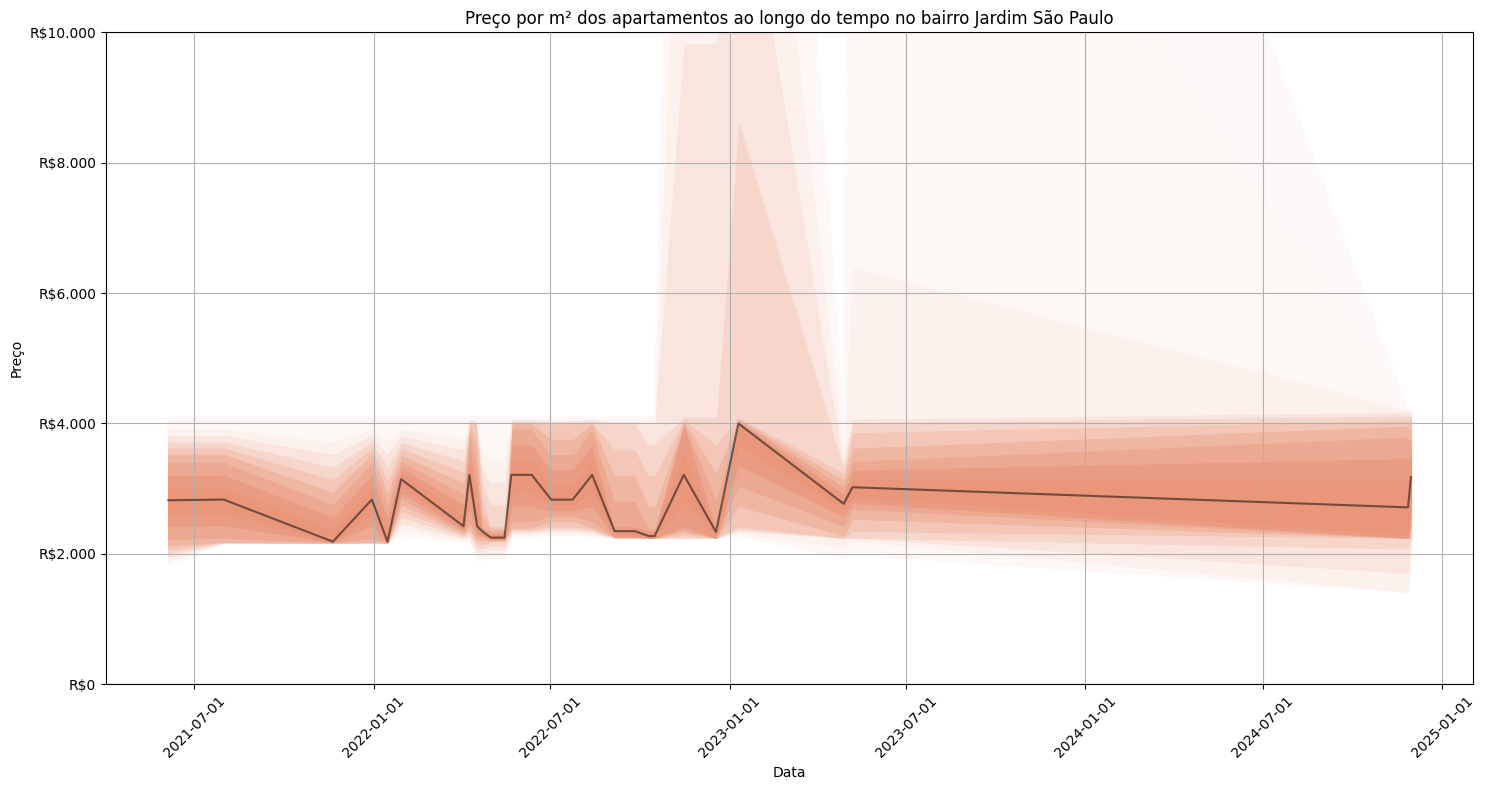

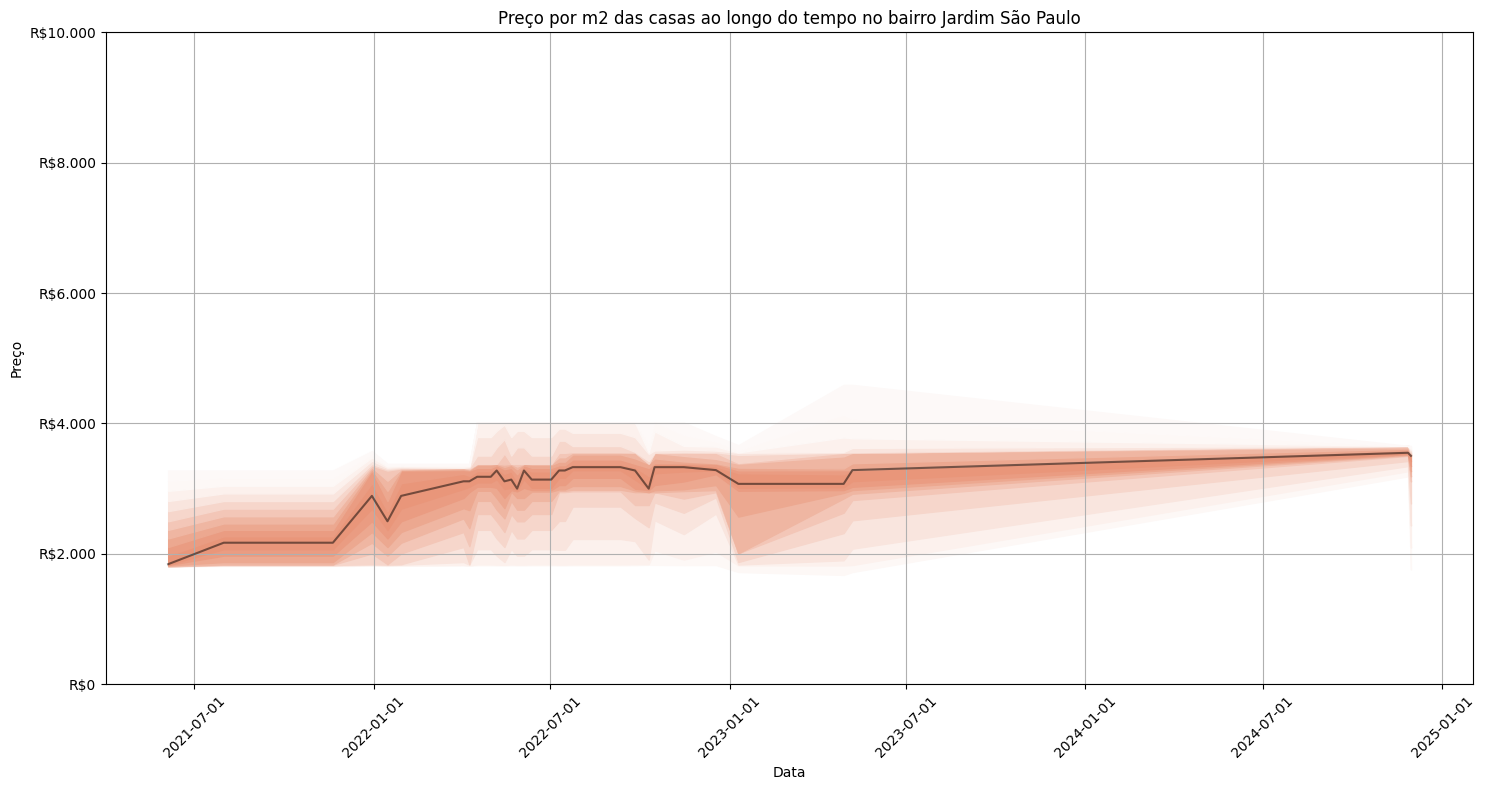

In [79]:
nome_do_bairro = "Jardim São Paulo"
bairro = data[data["neighbor"] == nome_do_bairro]
bairro = bairro[bairro["type"] == "Apartamento"]
bairro = bairro[~bairro["price"].isna()]
bairro = bairro[bairro["price"] > 0]
bairro["price"] = bairro["price"].astype(float)

percentile_plot(bairro, ylim=[0, 10_000], title=f"Preço por m² dos apartamentos ao longo do tempo no bairro {nome_do_bairro}", target_column="price_m2")

bairro = data[data["neighbor"] == nome_do_bairro]
bairro = bairro[bairro["type"] == "Casa"]
bairro = bairro[~bairro["price"].isna()]
bairro = bairro[bairro["price"] > 0]
bairro["price"] = bairro["price"].astype(float)
percentile_plot(bairro, ylim=[0, 10_000], title=f"Preço por m2 das casas ao longo do tempo no bairro {nome_do_bairro}", target_column="price_m2")

In [35]:
# data[data["neighbor"].fillna("").str.contains("loren")]

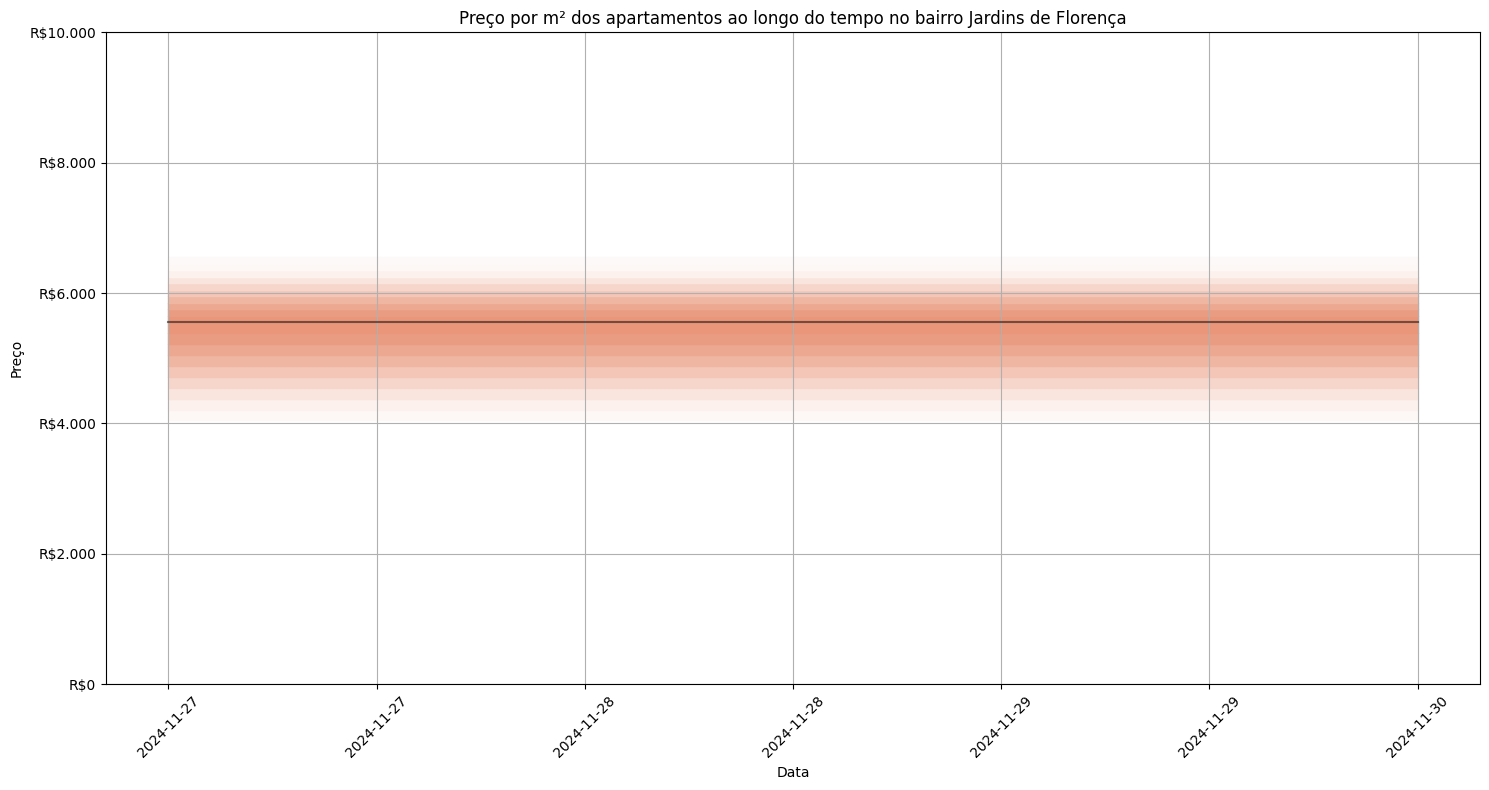

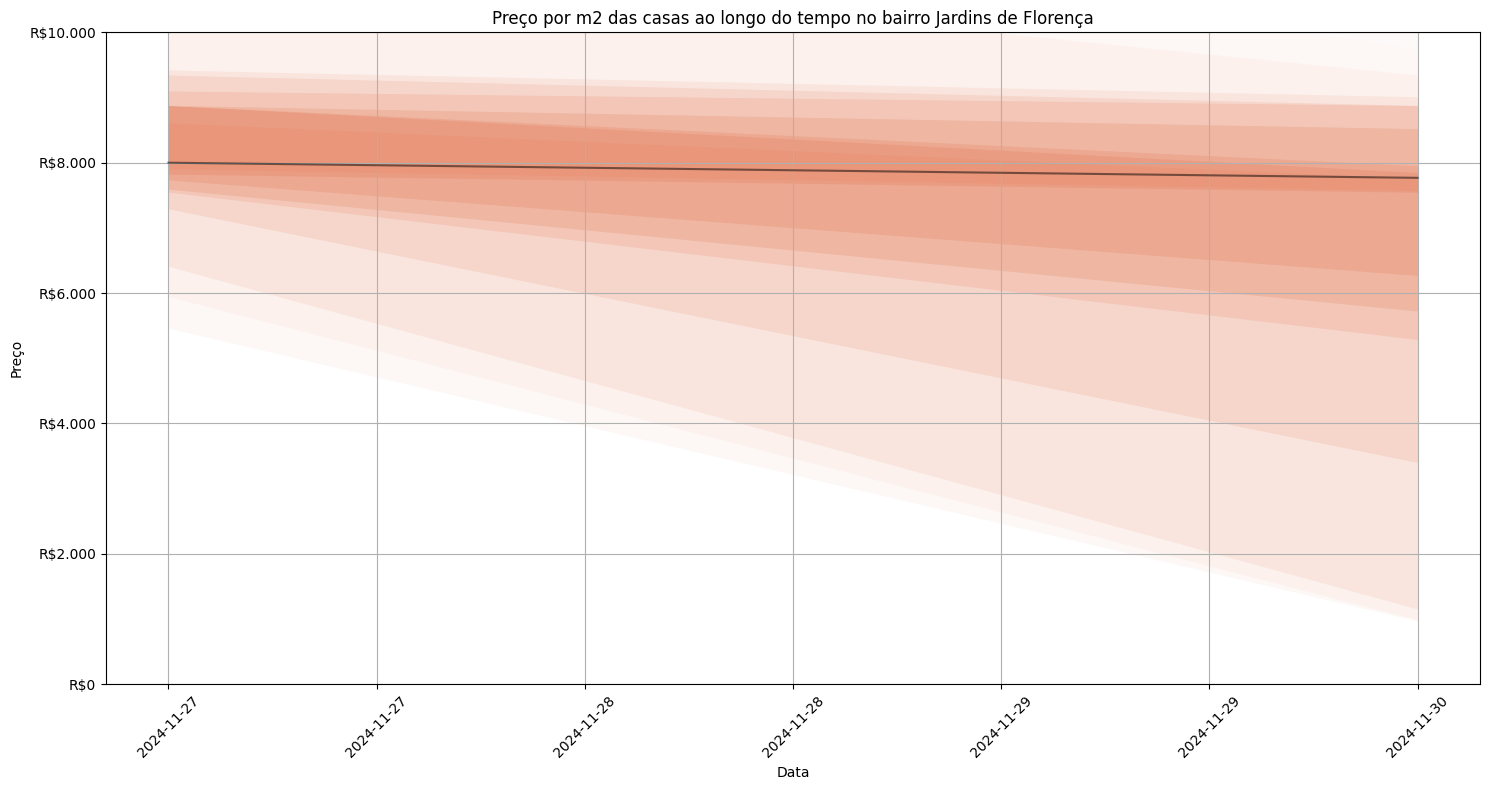

In [80]:
nome_do_bairro = "Jardins de Florença"

bairro = data[data["neighbor"] == nome_do_bairro]
bairro = bairro[bairro["type"] == "Apartamento"]
bairro = bairro[~bairro["price"].isna()]
bairro = bairro[bairro["price"] > 0]
bairro["price"] = bairro["price"].astype(float)

percentile_plot(bairro, ylim=[0, 10_000], title=f"Preço por m² dos apartamentos ao longo do tempo no bairro {nome_do_bairro}", target_column="price_m2")

bairro = data[data["neighbor"] == nome_do_bairro]
bairro = bairro[bairro["type"] == "Casa"]
bairro = bairro[~bairro["price"].isna()]
bairro = bairro[bairro["price"] > 0]
bairro["price"] = bairro["price"].astype(float)
percentile_plot(bairro, ylim=[0, 10_000], title=f"Preço por m2 das casas ao longo do tempo no bairro {nome_do_bairro}", target_column="price_m2")

In [87]:
# data[data["neighbor"].fillna("").str.contains("Jardim Europa")]

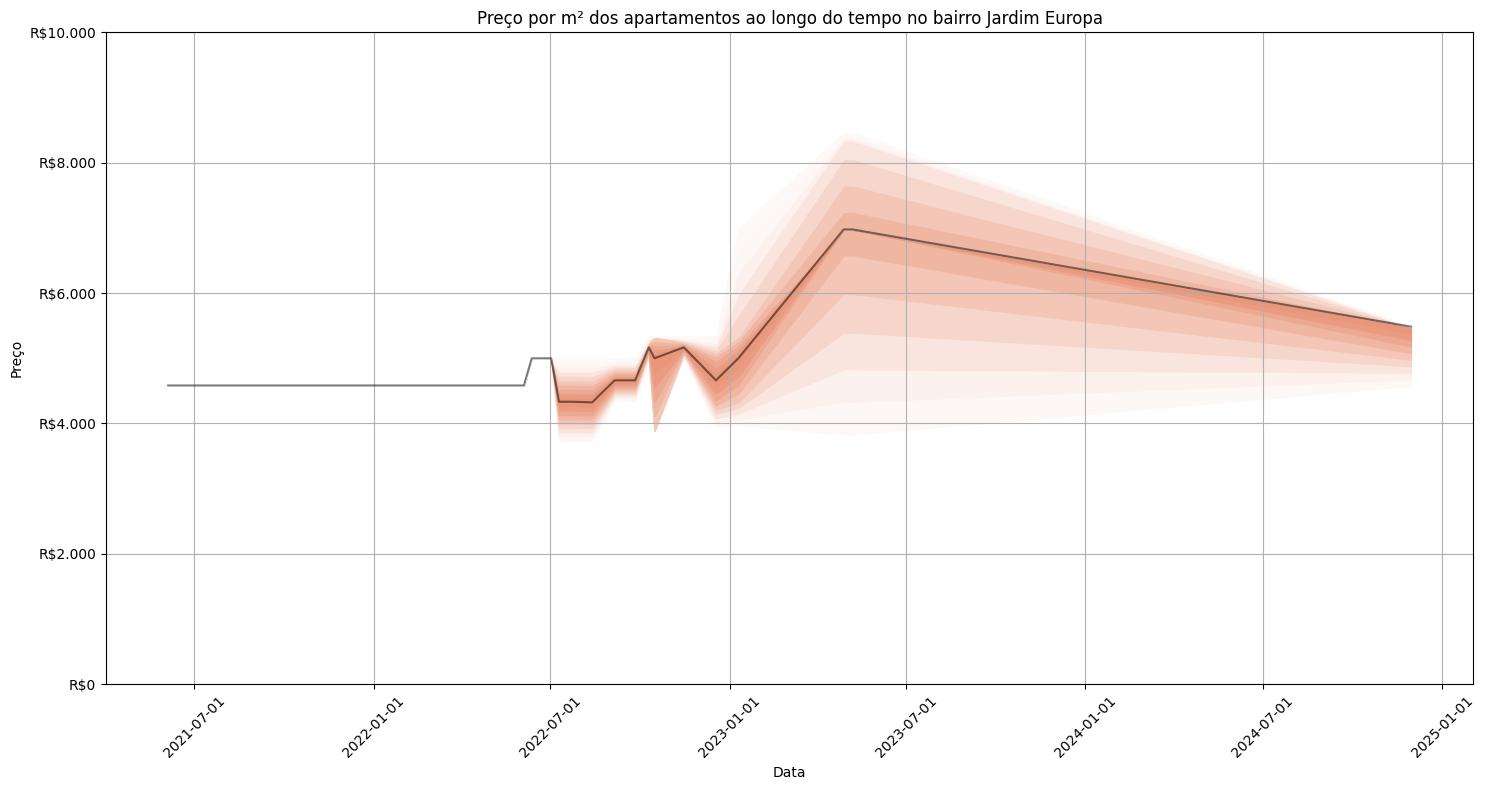

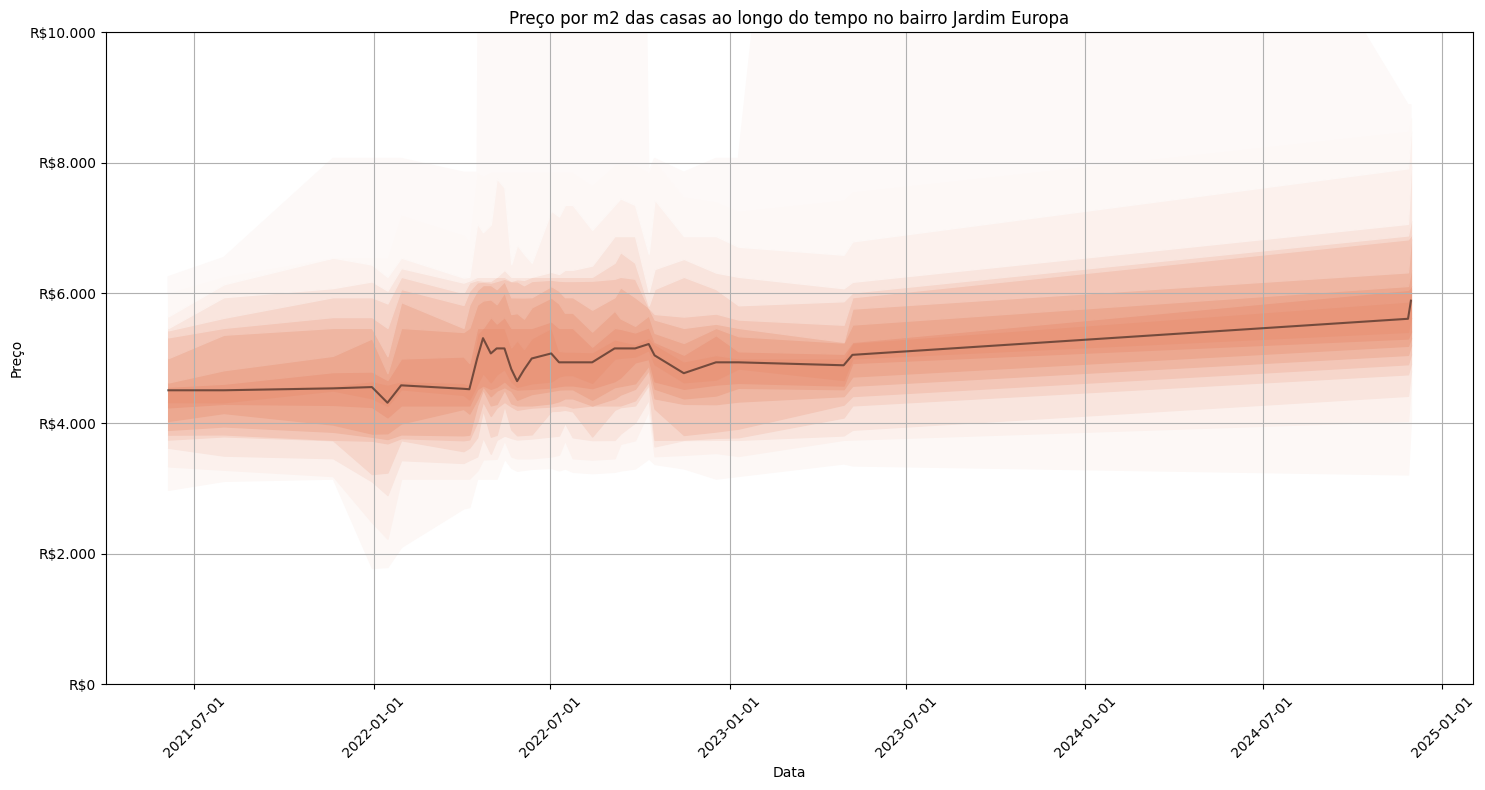

In [88]:
nome_do_bairro = "Jardim Europa"

bairro = data[data["neighbor"] == nome_do_bairro]
bairro = bairro[bairro["type"] == "Apartamento"]
bairro = bairro[~bairro["price"].isna()]
bairro = bairro[bairro["price"] > 0]
bairro["price"] = bairro["price"].astype(float)

percentile_plot(bairro, ylim=[0, 10_000], title=f"Preço por m² dos apartamentos ao longo do tempo no bairro {nome_do_bairro}", target_column="price_m2")

bairro = data[data["neighbor"] == nome_do_bairro]
bairro = bairro[bairro["type"] == "Casa"]
bairro = bairro[~bairro["price"].isna()]
bairro = bairro[bairro["price"] > 0]
bairro["price"] = bairro["price"].astype(float)
percentile_plot(bairro, ylim=[0, 10_000], title=f"Preço por m2 das casas ao longo do tempo no bairro {nome_do_bairro}", target_column="price_m2")

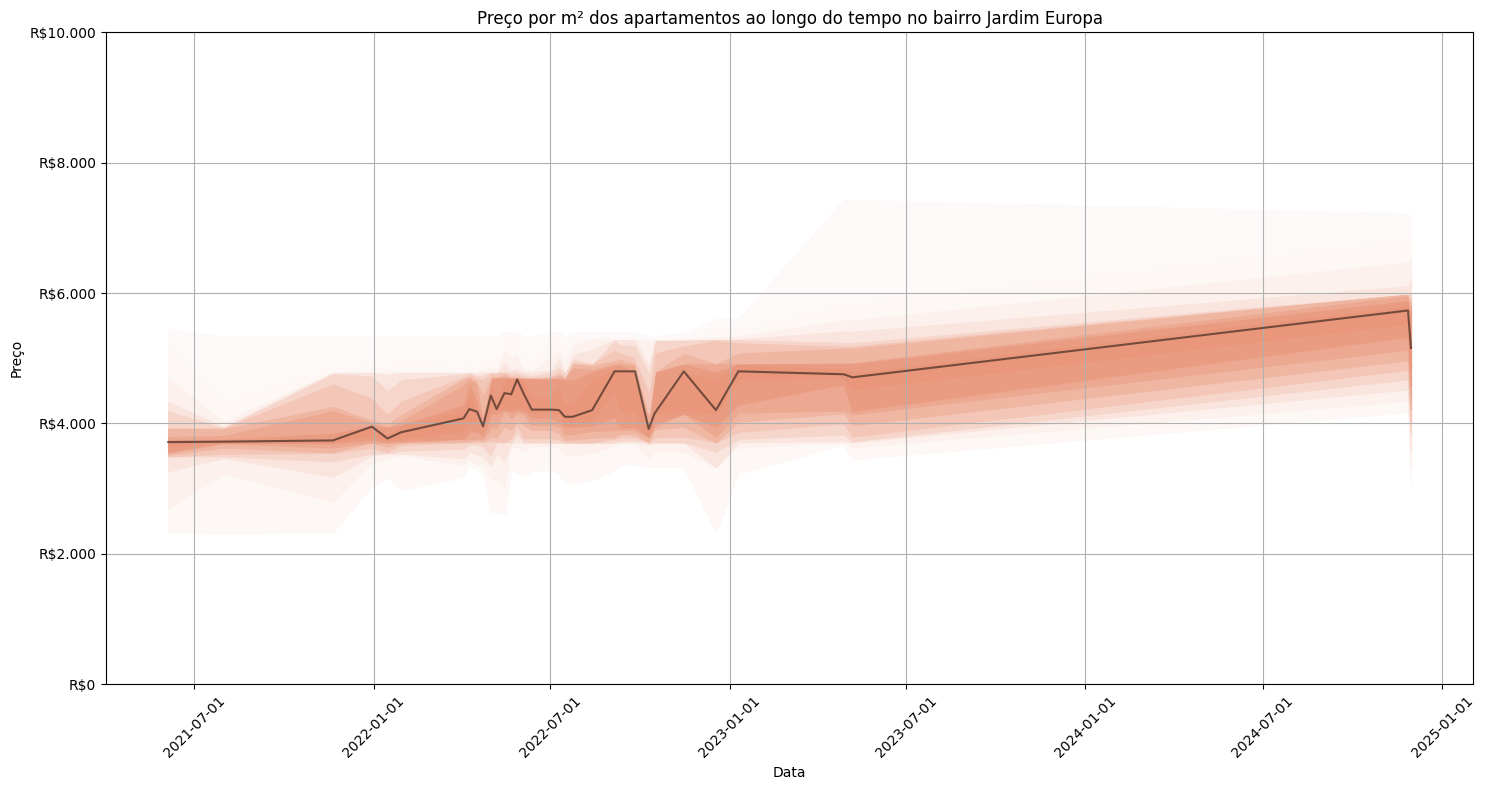

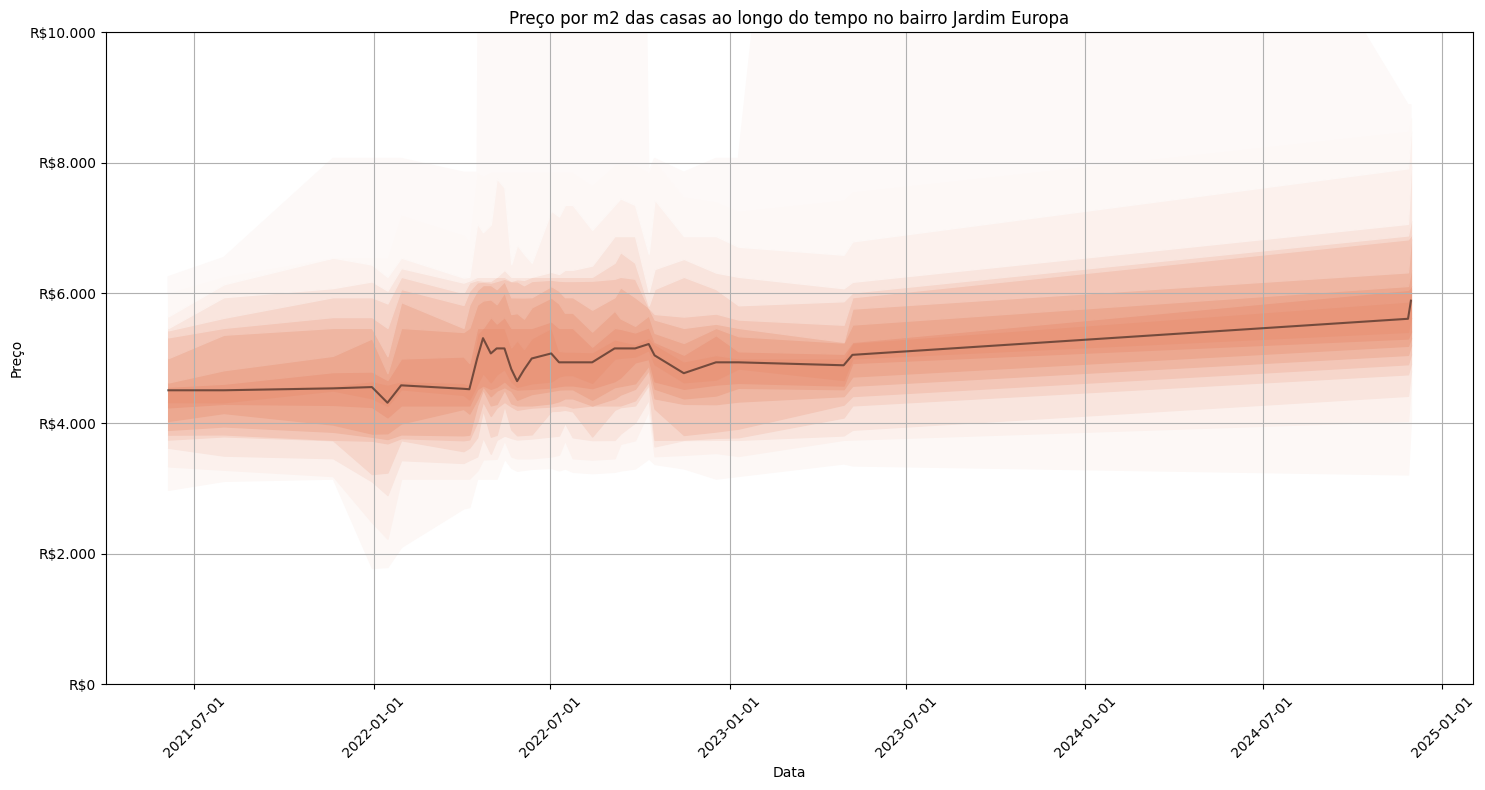

In [89]:
bairro = data[data["neighbor"].fillna("").str.contains("rimavera")]
bairro = bairro[bairro["type"] == "Apartamento"]
bairro = bairro[~bairro["price"].isna()]
bairro = bairro[bairro["price"] > 0]
bairro["price"] = bairro["price"].astype(float)

percentile_plot(bairro, ylim=[0, 10_000], title=f"Preço por m² dos apartamentos ao longo do tempo no bairro {nome_do_bairro}", target_column="price_m2")

bairro = data[data["neighbor"] == nome_do_bairro]
bairro = bairro[bairro["type"] == "Casa"]
bairro = bairro[~bairro["price"].isna()]
bairro = bairro[bairro["price"] > 0]
bairro["price"] = bairro["price"].astype(float)
percentile_plot(bairro, ylim=[0, 10_000], title=f"Preço por m2 das casas ao longo do tempo no bairro {nome_do_bairro}", target_column="price_m2")

In [9]:
data.to_csv("/app/pc_zap_scrapper/datasets/imoveis_2024_12_01.csv", index=False)